In [1]:
import matplotlib.pyplot as plt
import arviz as az
import numpy as np
import jax.numpy as jnp
from jax import random

import sys
sys.path.append("..")

from lqg.model import LQG
from lqg import xcorr

# Model

## Basic interface

My `lqg` package provides a flexible interface for LQG models. You can define your own $A$, $B$, $C$, $V$, $W$, $Q$, and $R$ matrices for a linear dynamical system of the following form

$$
\mathbf x_{t} = \mathbf x_{t-1} + B \, u_{t-1} + v_t,  \\
\mathbf y_t = C \mathbf x_t + w_t
$$

with Gaussian noise

$$
v_t \sim \mathcal{N}(0, V), \\
w_t \sim \mathcal{N}(0, W)
$$

We assume that the actor solves the linear-quadratic Gaussian problem, i.e. computes the Kalman filter $K$ and the LQR control law $L$, which are the optimal solution under the quadratic cost function

$$
J(u_{1:T}) =  \sum_{t=1}^T \mathbf x_t^T Q \mathbf x_t + \mathbf u_t^T R \mathbf u_t.
$$

The matrices need to be 2-dimensional `numpy.array`s.

E.g. for a one-dimensional tracking task, we can use

In [2]:
A = jnp.eye(2)
B = jnp.array([[0.], [1. / 6.]])

C = jnp.array([[1., -1.]])

V = jnp.diag(jnp.array([1., 0.5]))
W = jnp.array([[6.0]])

Q = jnp.array([[1., -1.], [-1., 1.]])
R = jnp.array([[1.]])

model = LQG(A, B, C, V, W, Q, R)
model

## Pre-defined models for the tracking task

For the models from the paper, I have defined classes with the corresponding names.

In [3]:
from lqg.tracking import BoundedActor

model = BoundedActor(c=0.5, motor_noise=0.5, sigma=6.)
model

# Simulations

For simulating trajectories, we simply run the state transition and observation equations above forward and return the trajectory $\mathbf x_{1:T}$.

We handle this by passing a seed to the `simulate` method, which is then used to call `np.random.seed`.

E.g., we simulate 20 trials from a tracking task with 500 time steps:

Simulations have shape: T = 500, n = 20, d = 2


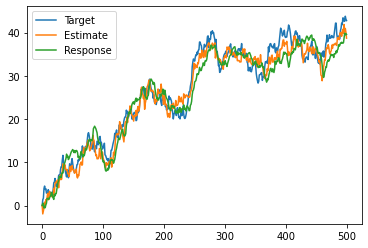

In [4]:
x, xhat, y, u = model.simulate(random.PRNGKey(0), n=20, T=500, return_all=True)
print("Simulations have shape: T = {}, n = {}, d = {}".format(*x.shape))

plt.plot(x[:,0,0], label="Target")
plt.plot(xhat[:,0,0], label="Estimate")
plt.plot(x[:,0,1], label="Response")

plt.legend()
plt.show()

## Cross-correlograms (CCGs)

Bonnen et al. (2015) analzye the data from a tracking task via cross-correlograms (Mulligan et al., 2013): the average autocorrelation of the velocities of target and response.

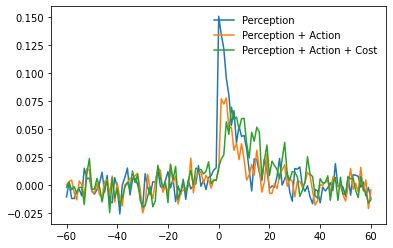

In [5]:
# compute cross-correlograms
model = BoundedActor(c=0., motor_noise=1., sigma=6.)
x, xhat, y, u = model.simulate(random.PRNGKey(0), n=20, T=500, return_all=True)


lags, corrs = xcorr(np.diff(xhat[..., 0], axis=0).T, np.diff(x[..., 0], axis=0).T)
plt.plot(lags, corrs.mean(axis=0), label="Perception")

lags, corrs = xcorr(np.diff(x[..., 1], axis=0).T, np.diff(x[..., 0], axis=0).T)
plt.plot(lags, corrs.mean(axis=0), label="Perception + Action")


model = BoundedActor(c=1., motor_noise=1., sigma=6.)
x, xhat, y, u = model.simulate(random.PRNGKey(0), n=20, T=500, return_all=True)

lags, corrs = xcorr(np.diff(x[..., 1], axis=0).T, np.diff(x[..., 0], axis=0).T)


plt.plot(lags, corrs.mean(axis=0), label="Perception + Action + Cost")
plt.legend(frameon=False)

## Influence of the parameters
### $c$

An increase in behavioral cost leads to an increased lag and decreased maximum correlation.

Text(0, 0.5, 'Autocorrelation')

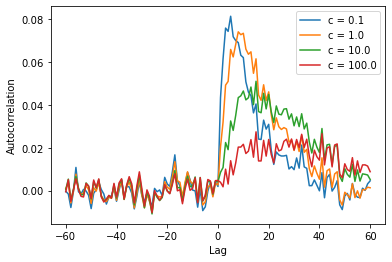

In [6]:
cs = np.logspace(-1, 2, 4, base=10)
for c in cs:
    # define model
    model = BoundedActor(c=c, motor_noise=0.5, sigma=12.)

    # simulate data
    x = model.simulate(random.PRNGKey(0), n=100, T=500)

    # compute cross-correlograms
    lags, corrs = xcorr(np.diff(x[..., 1], axis=0).T, np.diff(x[..., 0], axis=0).T)

    plt.plot(lags, corrs.mean(axis=0), label=f"c = {c:.1f}")
plt.legend()
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")

### $\sigma$

An increase in perceptual uncertainty leads to decreased correlation and increased lag, too, but the shape of the curves changes differently compared to the effect of the behavioral cost.

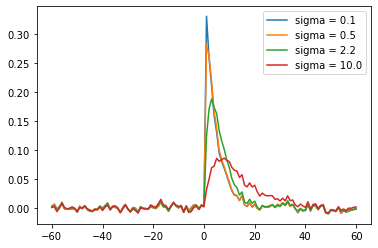

In [7]:
sigmas = np.logspace(-1, 1, 4, base=10)
for sigma in sigmas:
    model = BoundedActor(c=0.5, motor_noise=0.5, sigma=sigma)
    x = model.simulate(random.PRNGKey(0), n=100, T=500)

    lags, corrs = xcorr(np.diff(x[..., 1], axis=0).T, np.diff(x[..., 0], axis=0).T)

    plt.plot(lags, corrs.mean(axis=0), label=f"sigma = {sigma:.1f}")
plt.legend()

### $\sigma_m$

Action variability does not change the lag, but decreases correlation overall.

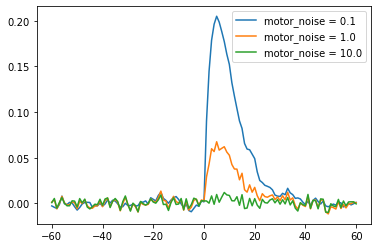

In [8]:
motor_noises = np.logspace(-1, 1, 3, base=10)
for motor_noise in motor_noises:
    model = BoundedActor(c=0.5, motor_noise=motor_noise, sigma=6.)
    x = model.simulate(random.PRNGKey(0), n=100, T=500)

    lags, corrs = xcorr(np.diff(x[..., 1], axis=0).T, np.diff(x[..., 0], axis=0).T)

    plt.plot(lags, corrs.mean(axis=0), label=f"motor_noise = {motor_noise:.1f}")
plt.legend()

### $\sigma_p$

Proprioceptive uncertainty does not change the shape of the CCGs at all, but does increase the mean squared error between target and response.

1027.1144
1073.6139
1250.8948
1758.8865


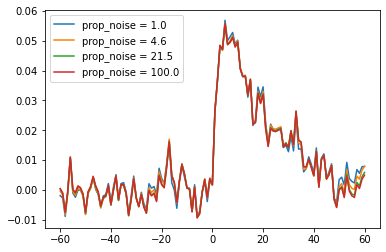

In [9]:
prop_noises = np.logspace(0, 2, 4, base=10)
for prop_noise in prop_noises:
    model = BoundedActor(c=.1, motor_noise=0.5, sigma=20., prop_noise=prop_noise)
    x = model.simulate(random.PRNGKey(0), n=100, T=500)

    lags, corrs = xcorr(np.diff(x[..., 1], axis=0).T, np.diff(x[..., 0], axis=0).T)
    
    print(np.sqrt(np.sum((x[...,1] - x[...,0])**2)))

    plt.plot(lags, corrs.mean(axis=0), label=f"prop_noise = {prop_noise:.1f}")
plt.legend()

## Subjective Model
You can also define a model, in which the true model (`Dynamics`) is different from the actor's model (`Actor`). For example, here is an actor who tracks the velocity when the true model only has a state.

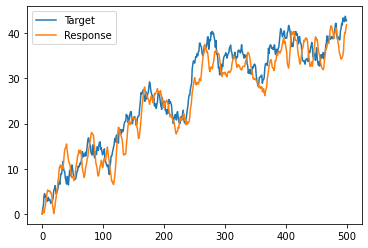

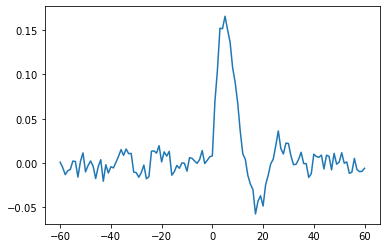

In [10]:
from lqg.model import System, Dynamics, Actor
from scipy import linalg

# setup true matrices of the environment
A = np.eye(2)
B = np.array([[0.], [1. / 6.]])

C = np.array([[1., -1.]])

V = np.diag(np.array([1., 0.5]))
W = np.array([[6.0]])

Q = np.array([[1., -1.], [-1., 1.]])
R = np.array([[1.]])

# setup the dynamics model
dynamics = Dynamics(A, B, C, V, W)

# setup the subjective matrices of the actor
A = linalg.block_diag(*[np.array([[1., 1 / 60.], [0., 1.]]), np.array([[1., 1 / 60.], [0., 1.]])])
B = np.array([[0.], [0.], [0.], [1. / 6.]])

C = np.array([[1., 0., -1., 0.]])

V = np.diag(np.array([0.1, 3., 0.5, 0.]))

Q = np.array([[1., 0., -1., 0.], [0., 0., 0., 0.], [-1., 0., 1., 0.], [0., 0., 0., 0.]])
R = np.array([[1.]])

# put the two together
actor = Actor(A, B, C, V, W, Q, R)
model = System(actor=actor, dynamics=dynamics)

x = model.simulate(random.PRNGKey(0), n=20, T=500)

plt.plot(x[:,0,0], label="Target")
plt.plot(x[:,0,1], label="Response")
plt.legend()
plt.show()

lags, corrs = xcorr(np.diff(x[..., 1], axis=0).T, np.diff(x[..., 0], axis=0).T)

plt.plot(lags, corrs.mean(axis=0))
plt.show()

# Inference

The cross-correlograms suggest that the parameters have quite different influences on $\mathbf x_{1:T}$, so we should be able to infer the parameters from the data. To run Bayesian inference for the three model parameters:

In [15]:
from lqg.infer import infer

# create model and simulate data
model = BoundedActor(c=1., motor_noise=0.5, sigma=12.)
x = model.simulate(random.PRNGKey(0), n=20, T=500)

# run inference and return numpyro MCMC object
mcmc = infer(x=x, model=BoundedActor, num_samples=5_000, num_warmup=2_500, method="nuts", progress_bar=True)

inference_data = az.convert_to_inference_data(mcmc)

sample: 100%|██████████| 7500/7500 [22:19<00:00,  5.60it/s, 7 steps of size 5.57e-02. acc. prob=0.93]   


array([[<AxesSubplot:ylabel='motor_noise'>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='prop_noise'>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='c', ylabel='sigma'>,
        <AxesSubplot:xlabel='motor_noise'>,
        <AxesSubplot:xlabel='prop_noise'>]], dtype=object)

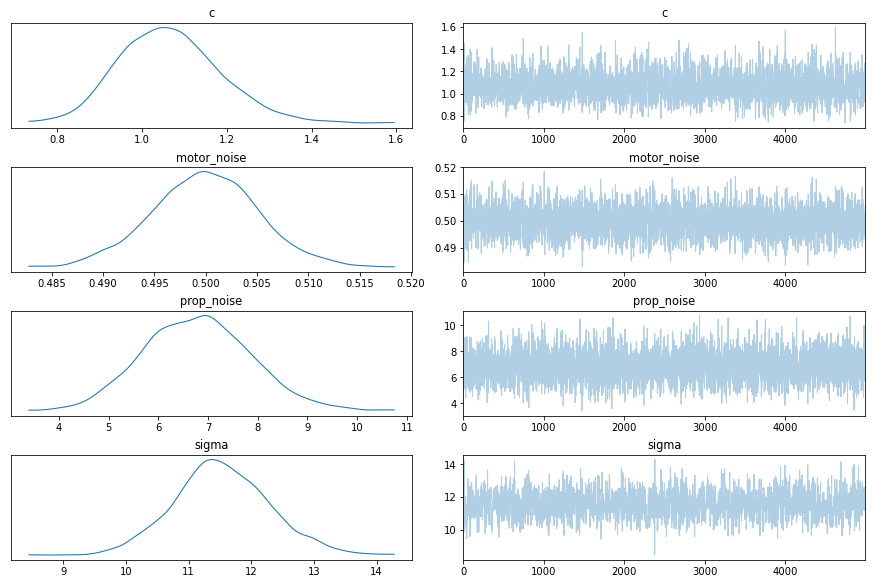

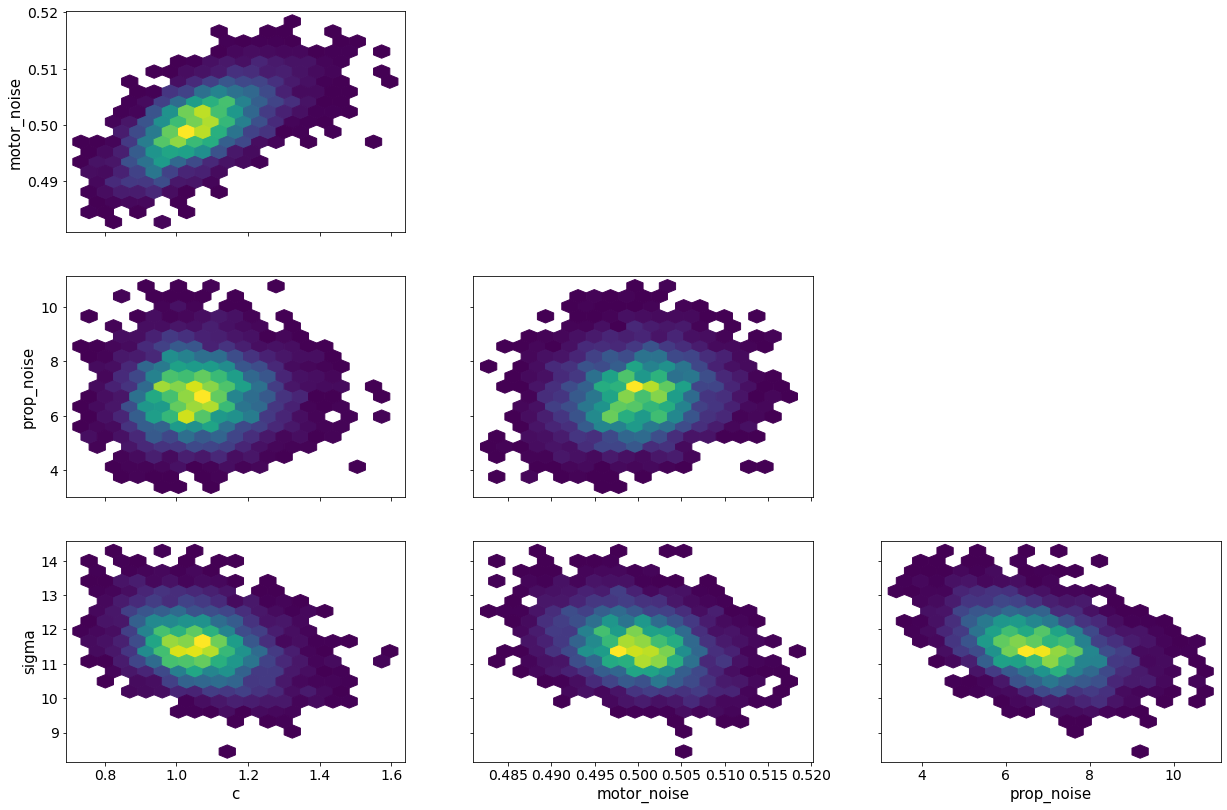

In [16]:
# trace plot
az.plot_trace(inference_data)

# pair plots
az.plot_pair(inference_data, kind="hexbin")